In [3]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

어떤 이미지를 출력하시겠습니까?
0 img1.ppm
1 img2.ppm
2 img3.ppm
3 img4.ppm
4 img5.ppm
5 img6.ppm


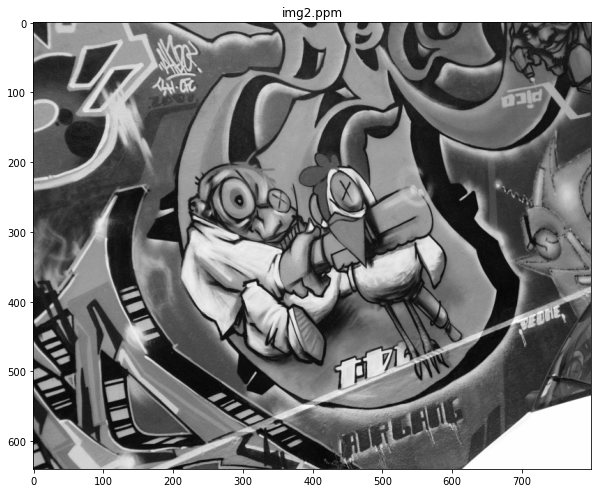

In [4]:
PATH = '/home/sumin/Documents/robot_vision/SIFT'
images = os.listdir(PATH)
images = sorted(images)
print('어떤 이미지를 출력하시겠습니까?')
for cnt, name in enumerate(images):
    print(cnt, name)
cnt = int(input())
image = cv2.imread(f'{PATH}/{images[cnt]}')
#matplotlib 출력시
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,10))
plt.title(f'{images[cnt]}')
plt.imshow(image,cmap='gray')
plt.show()


In [19]:
def show(img):
    plt.figure(figsize = (10,10))
    plt.imshow(img,cmap= 'gray')
    plt.show()
    

In [28]:
def gaussian_kernel(kernel_size, sigma):
    size = kernel_size//2
    y, x = np.ogrid[-size:size+1, -size:size+1] 
    filter = 1/(2*np.pi * (sigma**2)) * np.exp(-1 *(x**2 + y**2) /(2*(sigma**2))) 
    sum = filter.sum() 
    filter /= sum 
    return filter



In [29]:
def padding(img, k_size):
    pad_size = k_size//2
    rows, cols= img.shape
    res = np.zeros((rows + (2*pad_size), cols+(2*pad_size)), dtype=np.uint8) 
    if pad_size == 0: 
        res = img.copy() 
    else: 
        res[pad_size:-pad_size, pad_size:-pad_size] = img.copy() 
    return res




In [30]:
def gaussian_filtering(img, k_size=3,sigma=1): 
    rows, cols = img.shape 
    filter = gaussian_kernel(k_size, sigma)
    pad_img = padding(img,k_size) 
    filtered_img = np.zeros((rows, cols), dtype=np.float32) 
    
    for i in range(rows): 
        for j in range(cols): filtered_img[i, j] = np.sum(filter * pad_img[i:i+k_size, j:j+k_size]) 
    return filtered_img.astype(np.uint8)


# Make a Scale Space 

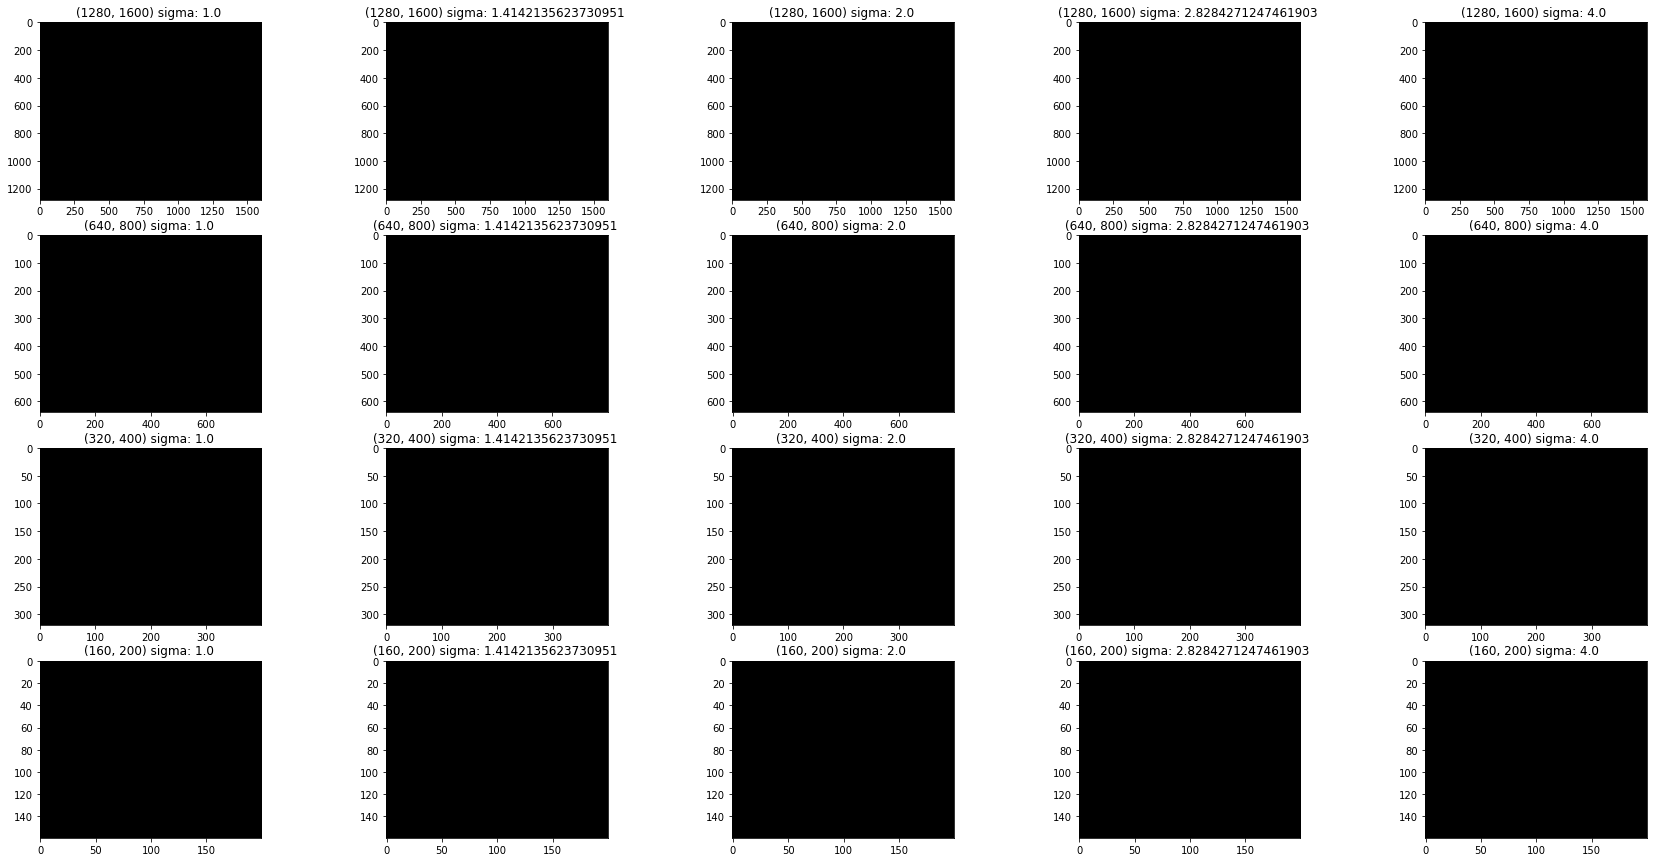

In [31]:
Octave =[]

for i in range (4):
    img = []
    tmp = cv2.resize(image,(int(image.shape[1]*2**(1-i)),int(image.shape[0]*2**(1-i))))
    for j in range(5):
        img.append(gaussian_filtering(tmp, 0,2**(j/2)))
    Octave.append(img)

plt.figure(figsize=(30,15))
cnt = 1
for j in range(4):
    for i in range(5):    
        plt.subplot(4,5,cnt)
        plt.title(f'{Octave[j][i].shape} sigma: {2**(i/2)} ')
        plt.imshow(Octave[j][i],cmap='gray')
        cnt+=1
plt.show()



# DoG Calculation

- Using Laplacian of Gaussian(LoG) --> Key Points


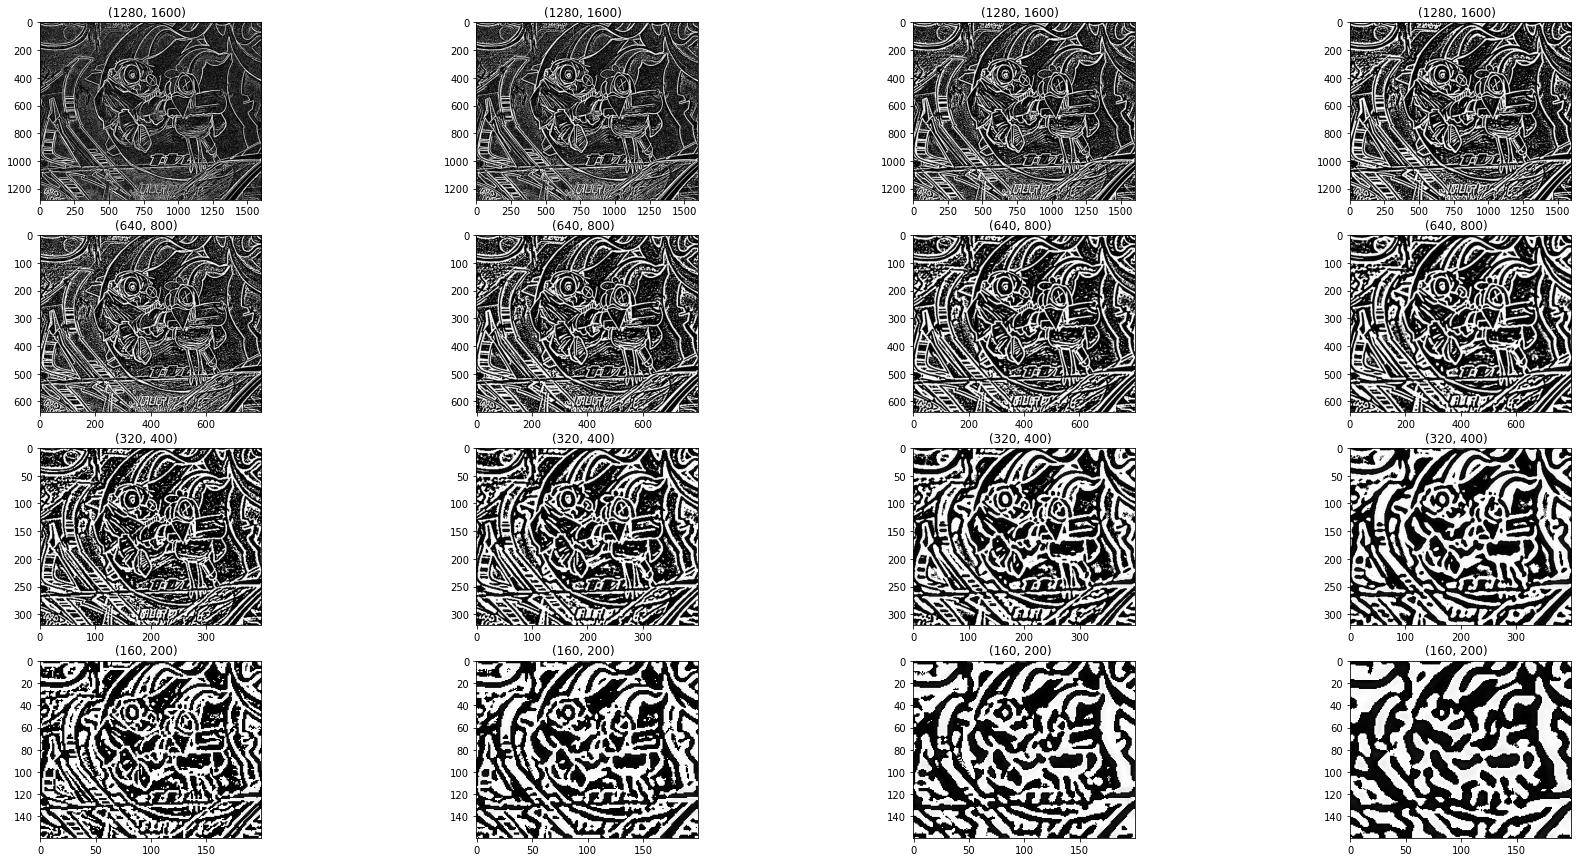

In [35]:
DoG=[] 
for i in range(4):
    tmp =[]
    for j in range(4):
        tmp.append(Octave[i][j] - Octave[i][j+1])
    DoG.append(tmp)
len(DoG)
plt.figure(figsize=(30,15))
cnt = 1
for j in range(4):
    for i in range(4):    
        plt.subplot(4,4,cnt)
        plt.title(f'{DoG[j][i].shape}  ')
        plt.imshow(DoG[j][i],cmap='gray')
        cnt+=1
plt.show()

# Keypoint 찾기

- 위에서 구한 극값들의 위치는 대략적인 것입니다
- 하지만 우리는 진짜 극값의 위치에 접근할 수 없기 때문에 수학적으로 계산
- 아래의 식을 X에 대해 미분해서 0이 되는 지점이 극값

In [36]:
from tqdm.notebook import tqdm 
Key_Points = [] 
for j in range(4):
    tmp = [] 
    for i in tqdm(range(1,3)):
        key = np.zeros_like(DoG[j][0])
        print(j, i)  
        for y in range(1, len(key[:-1,0])):
            for x in range(1, len(key[0,:-1])):
                lis =[DoG[j][i][y-1][x-1],DoG[j][i][y-1][x],DoG[j][i][y-1][x+1],DoG[j][i][y][x-1],DoG[j][i][y][x],DoG[j][i][y][x+1],DoG[j][i][y+1][x-1],DoG[j][i][y+1][x],DoG[j][i][y+1][x+1],
                        DoG[j][i-1][y-1][x-1],DoG[j][i-1][y-1][x],DoG[j][i-1][y-1][x+1],DoG[j][i-1][y][x-1],DoG[j][i-1][y][x],DoG[j][i-1][y][x+1],DoG[j][i-1][y+1][x-1],DoG[j][i-1][y+1][x],DoG[j][i-1][y+1][x+1],
                        DoG[j][i+1][y-1][x-1],DoG[j][i+1][y-1][x],DoG[j][i+1][y-1][x+1],DoG[j][i+1][y][x-1],DoG[j][i+1][y][x],DoG[j][i+1][y][x+1],DoG[j][i+1][y+1][x-1],DoG[j][i+1][y+1][x],DoG[j][i+1][y+1][x+1]]
                #import pdb;pdb.set_trace()
                if DoG[j][i][y][x].all() == np.min(lis) or DoG[j][i][y][x].all() == np.max(lis):
                    key[y][x] = DoG[j][i][y][x]
        tmp.append(key)
    Key_Points.append(tmp)
print(len(Key_Points))

  0%|          | 0/2 [00:00<?, ?it/s]

0 1
0 2


  0%|          | 0/2 [00:00<?, ?it/s]

1 1
1 2


  0%|          | 0/2 [00:00<?, ?it/s]

2 1
2 2


  0%|          | 0/2 [00:00<?, ?it/s]

3 1
3 2
4


## 나쁜 Key Point 제거 

- 나쁜 keypoint들을 제거하기 위해 수학적으로 계산된 keypoint들 중에서 특정 threshold 보다 낮은 keypoint들을 제거

In [40]:
Good_Key_Point =[]
threshold = 100

for j in range(4):
    tmp = [] 
    for i in tqdm(range(2)):
        key = np.zeros_like(Key_Points[j][0])
        print(j, i)  
        for y in range( key.shape[0]):
            for x in range( key.shape[1]):
                if Key_Points[j][i][y,x] < threshold:    
                    key[y,x] = 0
                else :
                    key[y,x] = Key_Points[j][i][y,x] 

        tmp.append(key)
    Good_Key_Point.append(tmp)



  0%|          | 0/2 [00:00<?, ?it/s]

0 0
0 1


  0%|          | 0/2 [00:00<?, ?it/s]

1 0
1 1


  0%|          | 0/2 [00:00<?, ?it/s]

2 0
2 1


  0%|          | 0/2 [00:00<?, ?it/s]

3 0
3 1


# Orientation Assignment
- Keypoint 마다 방향을 할당해주는 역할을 해주는 단계입니다.
- Keypoint 주변으로 아래의 두 식을 이용해서 keypoint 주변 gradient의 크기 및 방향을 알아낼 수 있습니다.

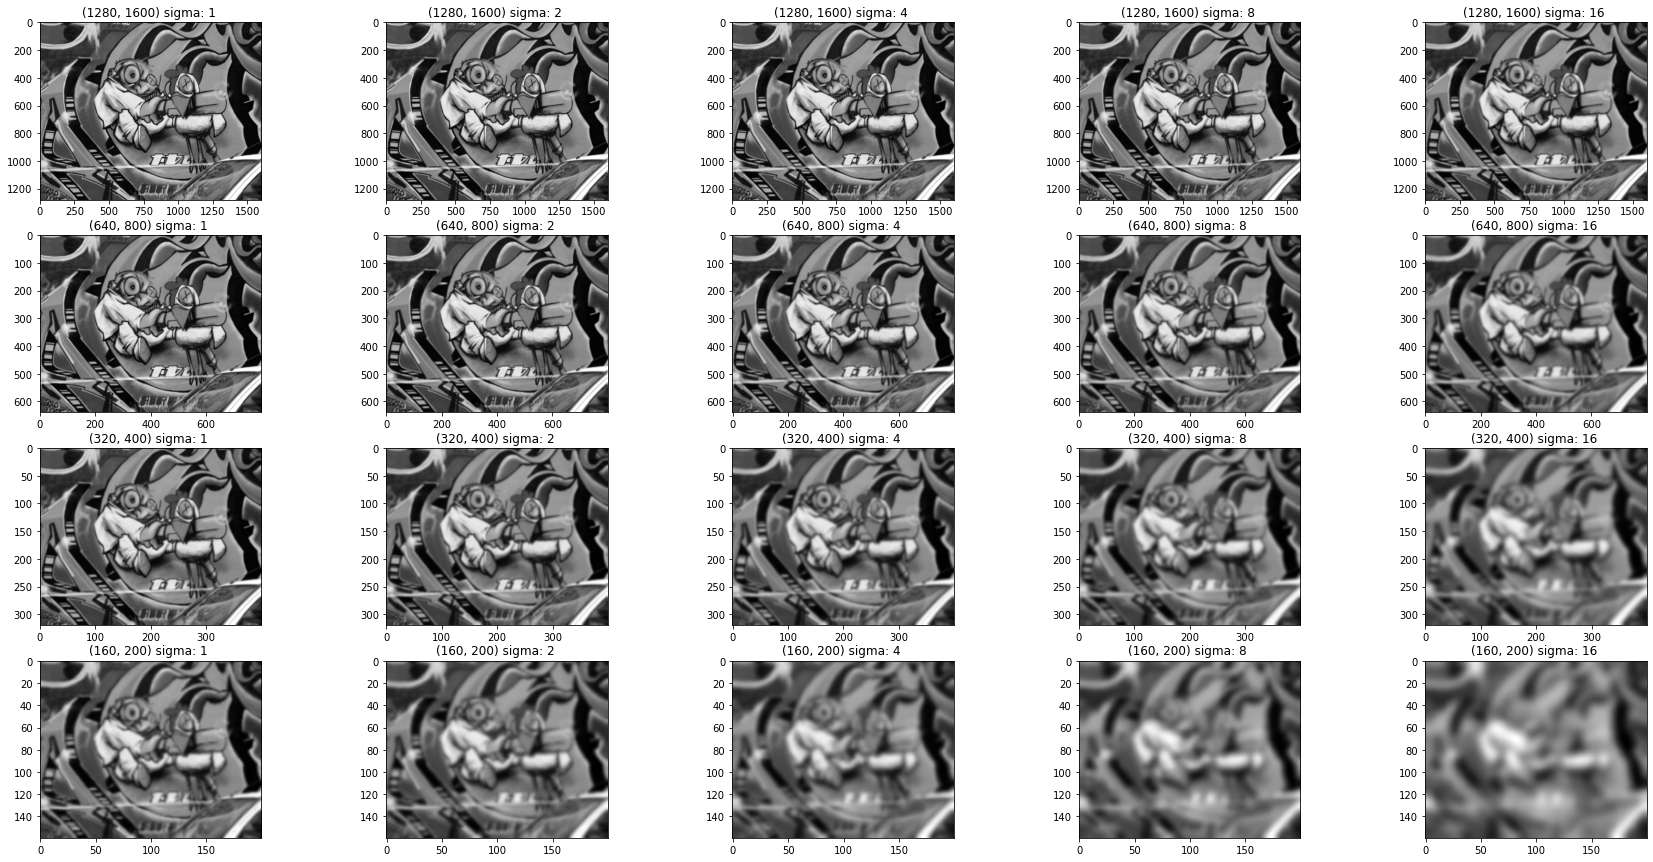

In [37]:
plt.figure(figsize=(30,15))
cnt = 1
for j in range(4):
    for i in range(5):    
        plt.subplot(4,5,cnt)
        plt.title(f'{Octave[j][i].shape} sigma: {2**i} ')
        plt.imshow(Octave[j][i],cmap='gray')
        cnt+=1
plt.show()


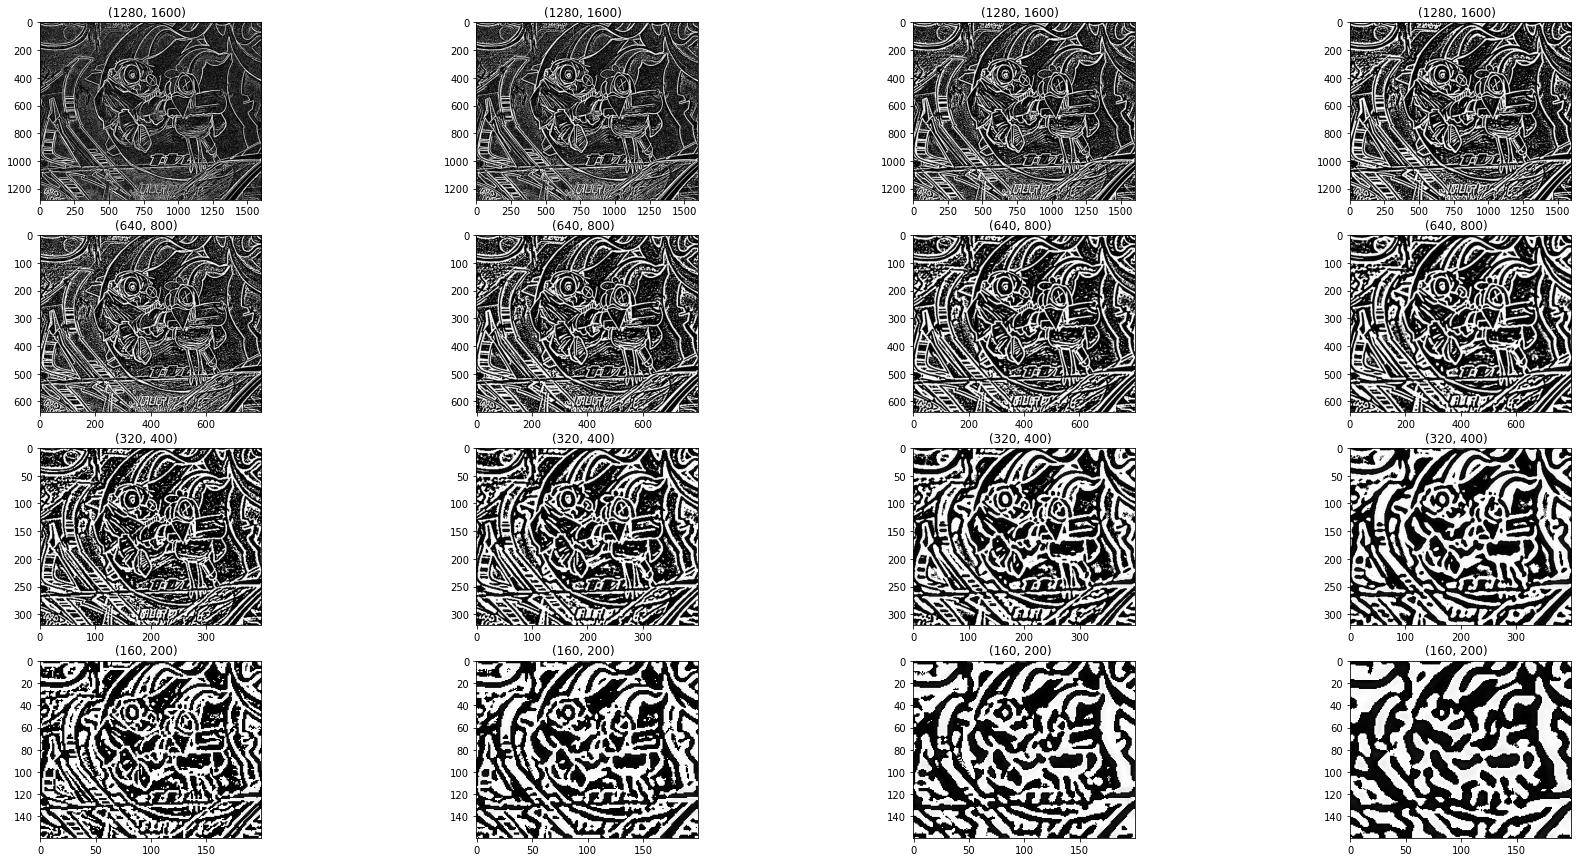

In [38]:
plt.figure(figsize=(30,15))
cnt = 1
for j in range(4):
    for i in range(4):    
        plt.subplot(4,4,cnt)
        plt.title(f'{DoG[j][i].shape}  ')
        plt.imshow(DoG[j][i],cmap='gray')
        cnt+=1
plt.show()

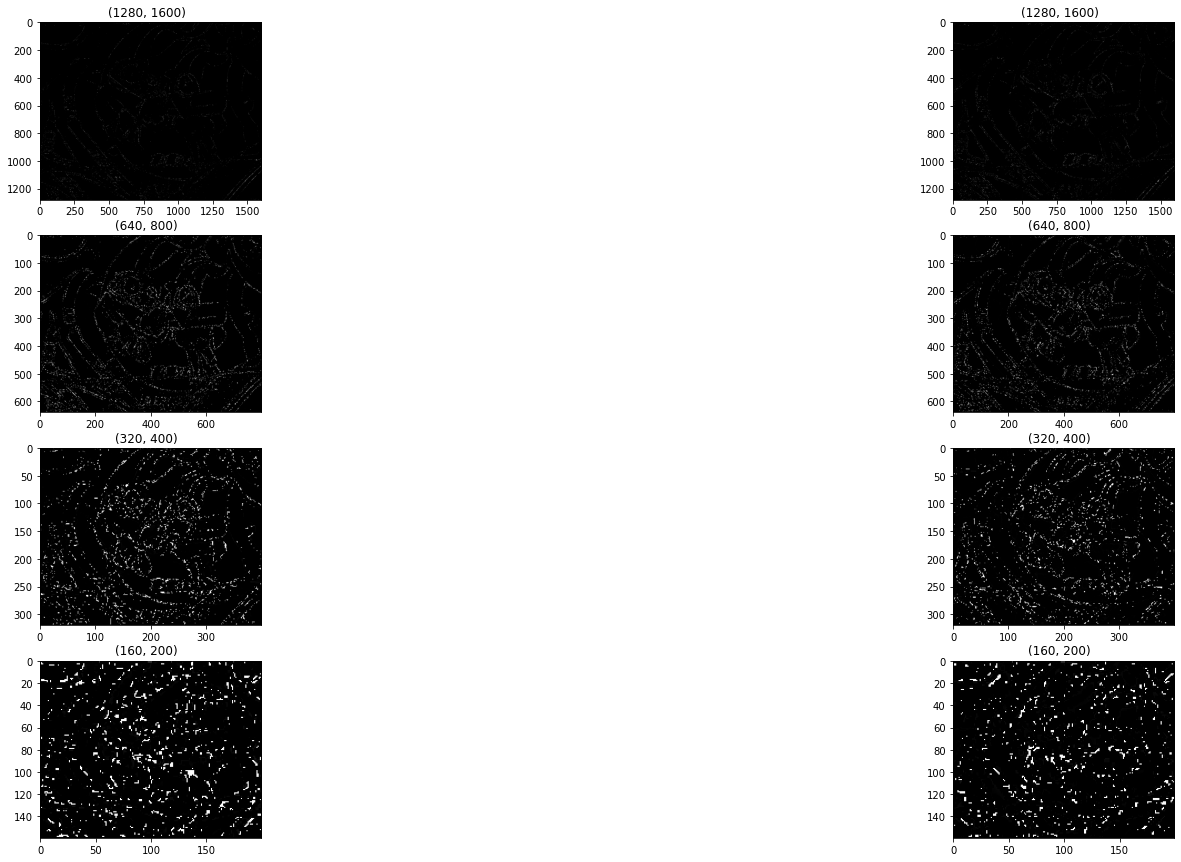

In [39]:
plt.figure(figsize=(30,15))
cnt = 1
for j in range(4):
    for i in range(2):    
        plt.subplot(4,2,cnt)
        plt.title(f'{Key_Points[j][i].shape}  ')
        plt.imshow(Key_Points[j][i],cmap='gray')
        cnt+=1
plt.show()


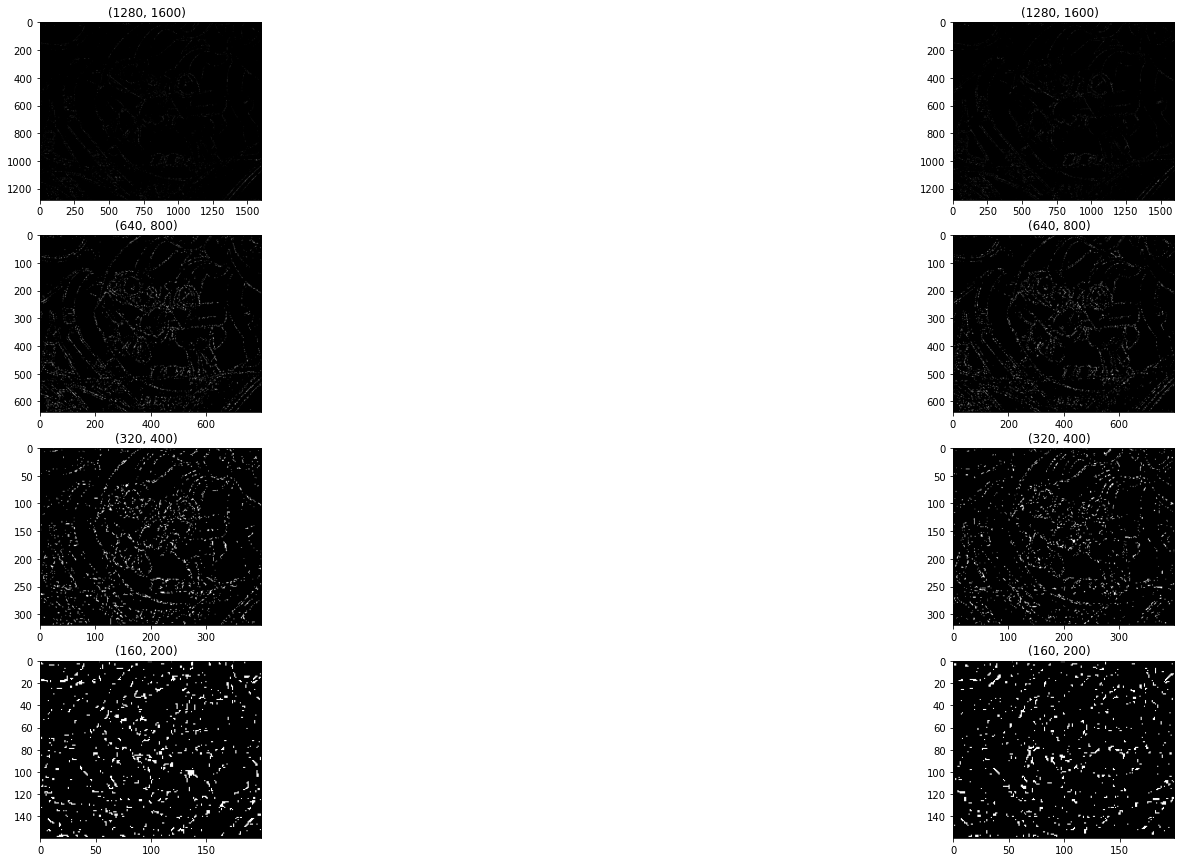

In [41]:
plt.figure(figsize=(30,15))
cnt = 1
for j in range(4):
    for i in range(2):    
        plt.subplot(4,2,cnt)
        plt.title(f'{Good_Key_Point[j][i].shape}  ')
        plt.imshow(Good_Key_Point[j][i],cmap='gray')
        cnt+=1
plt.show()


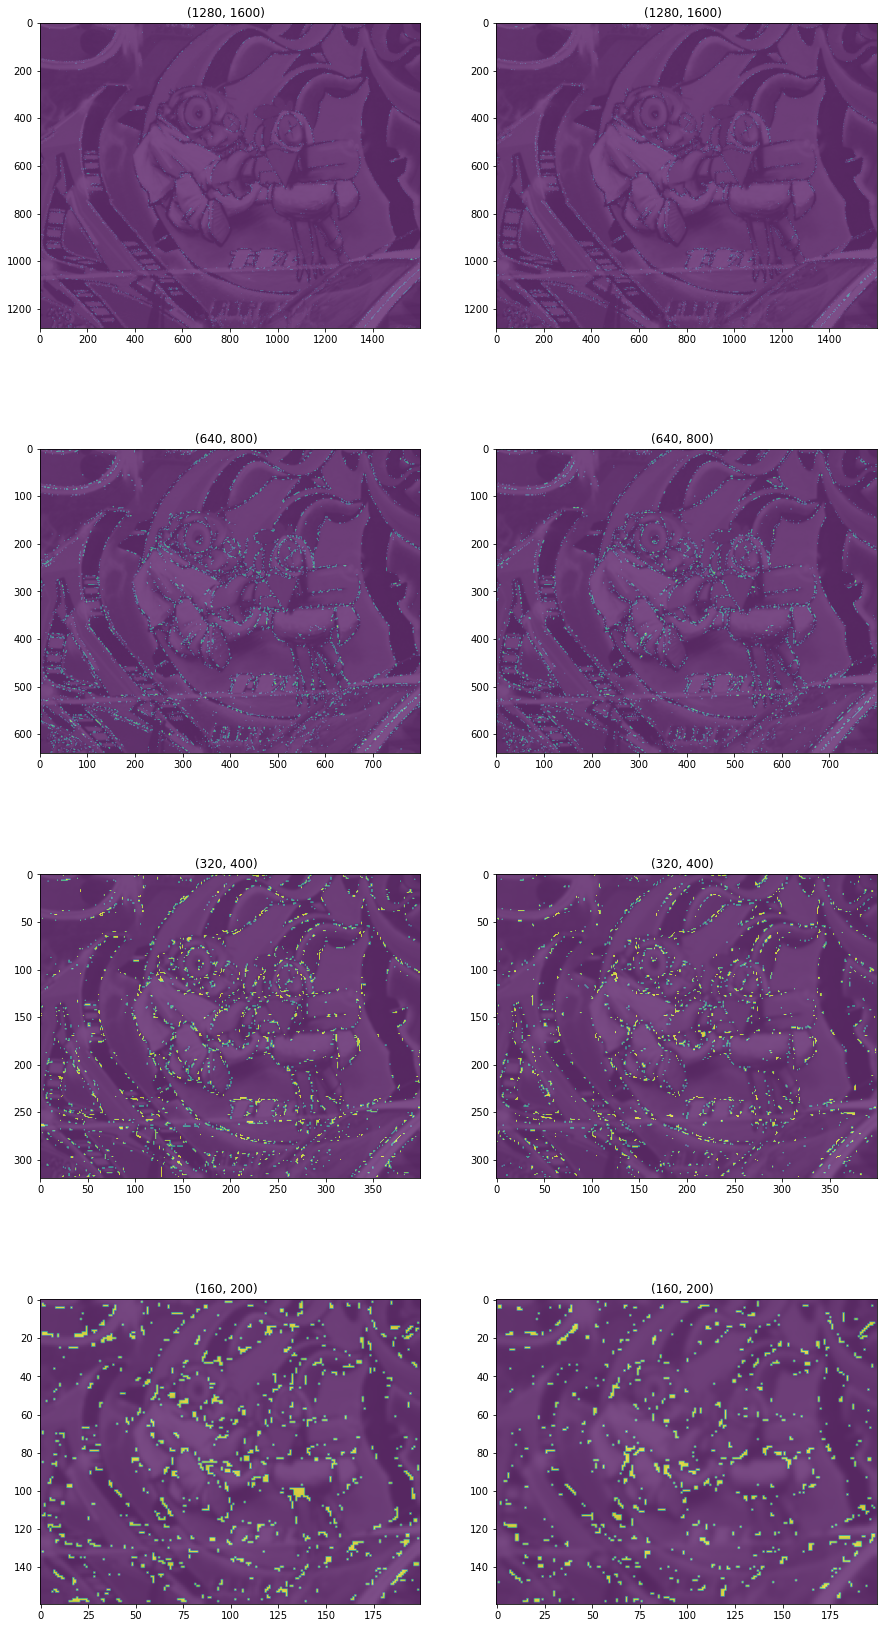

In [45]:
plt.figure(figsize=(15,30))
cnt = 1
for j in range(4):
    for i in range(2):    
        plt.subplot(4,2,cnt)
        plt.title(f'{Good_Key_Point[j][i].shape}  ')
        plt.imshow(Octave[j][i],cmap='gray',alpha=0.5)
        plt.imshow(Good_Key_Point[j][i],alpha =0.7)
        cnt+=1
plt.show()
